<a href="https://colab.research.google.com/github/rkj26/textClassifier/blob/master/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
!pip install selenium

In [0]:
import re
from string import ascii_uppercase
import pandas as pd
import numpy as np
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import string

In [0]:
from random import randint
import datetime

In [0]:

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [0]:
ports = []
vessels = []
companies = []

In [0]:
temp = 'https://directories.lloydslist.com/port-browse-name/searchid/0/searchchar/'  #This part is link of the search query that is constant so I decided to hardcode it
for c in ascii_uppercase:
  i = 1
  url = temp + c # Go over all the letters in alphabets and store the ports
  wd = webdriver.Chrome('chromedriver',options=chrome_options)
  while(True):              # As each page has different number of results, using try and except to break the loop when there are no results left to store.
    try:
      if i == 1:
        wd.get(url=url)
        souplevel = BeautifulSoup(wd.page_source, 'lxml')
      else:
        button = wd.find_element_by_link_text(str(i))
        button.click()
        souplevel = BeautifulSoup(wd.page_source, 'lxml')

      for child in souplevel.find_all('a', href=re.compile('port-browse-listing/portid')): #All ports are stored using this template therefore used regular expression to find all <a href = ''></a> tags and stored their text. 
        if child.text != 'Learn More':
          ports.append(child.text) 
    
      i+=1
    except:
      break

In [0]:
NO_OF_PAGES=25 #Only 25 pages to view therefore hard coded it.
wd = webdriver.Chrome('chromedriver',options=chrome_options)
url = 'https://www.marinetraffic.com/en/data/?asset_type=vessels&columns=flag,shipname,photo,recognized_next_port,reported_eta,reported_destination,current_port,imo,ship_type,show_on_live_map,time_of_latest_position,lat_of_latest_position,lon_of_latest_position'
wd.get(url=url)
for i in range(NO_OF_PAGES):
  button = WebDriverWait(wd, 20).until(EC.presence_of_element_located((By.XPATH, '//*[@id="reporting_ag_grid"]/div/div[2]/div[3]/div/div/div/div/div[3]/button[2]')))
  if i!=0:
    button.click()
  soup = BeautifulSoup(wd.page_source, 'lxml')
  for element in soup.find_all('a', href=re.compile('/en/ais/details/ships/')): #Similar thought as the for port web scrapper.
    vessels.append(element.text)

In [0]:
url = 'https://opencorporates.com/registers'
wd = webdriver.Chrome('chromedriver',options=chrome_options)
wd.get(url)
soup = BeautifulSoup(wd.page_source, 'lxml')
numberOfRegistries = int(soup.find(id='DataTables_Table_0_info').text.split(' ')[-2]) #Finding out the number of registries
for i in range(numberOfRegistries):
  xpath = '//*[@id="DataTables_Table_0"]/tbody/tr['+str(i+1)+']/td[3]/a' #Every row of the table and third column which is a clickable link to the companies.
  companiesLink = WebDriverWait(wd, 20).until(EC.presence_of_element_located((By.XPATH, xpath)))
  companiesLink.click()
  lookup = str(wd.current_url)[26:]+'/'  #Lookup for the directory link which is used for every company in the registry

  for j in range(3): 
    if j != 0:
      nextPath = '//*[@id="results"]/div/div[1]/ul/li[8]/a'  #XPath for the next button
      nextButton = wd.find_element_by_xpath(nextPath)
      nextButton.click()
        
    subSoup = BeautifulSoup(wd.page_source, 'lxml')
    for k in subSoup.find_all('a', href=re.compile(lookup)):
      companies.append(k.text)
  wd.get(url)

In [0]:
ports = np.array(ports)
vessels = np.array(vessels)
companies = np.array(companies)

In [10]:
print(len(ports))
print(len(vessels))
print(len(companies))

6657
500
12512


In [0]:
def dateGenerator():
  i = randint(0,4)
  dd, mm, yyyy = randomGenerator()
  correct = check_date(yyyy, mm, dd)
  if correct:
    date = datetime.datetime(yyyy, mm, dd)
    if i==0:
      date = "{0:0=2d}".format(dd)+'/'+"{0:0=2d}".format(mm)+'/'+str(yyyy)
    elif i==1:
      date = "{0:0=2d}".format(mm)+'/'+"{0:0=2d}".format(dd)+'/'+str(yyyy)
    elif i==2:
      date = str(yyyy)+'/'+"{0:0=2d}".format(mm)+'/'+"{0:0=2d}".format(dd)
    elif i==3:
      date = date.strftime("%b %d %Y")
    elif i==4:
      date = date.strftime("%B %d %Y")
    return date
  else:
    return dateGenerator()

In [0]:
def randomGenerator():
  dd = randint(1,31)
  mm = randint(1,12)
  yyyy = randint(1970, 2020)
  return dd, mm, yyyy

In [0]:
def check_date(year, month, day):
    correctDate = None
    try:
        newDate = datetime.datetime(year, month, day)
        correctDate = True
    except ValueError:
        correctDate = False
    return correctDate

In [0]:
dates = []

In [0]:
for i in range(500):
  dates.append(dateGenerator())

In [0]:
df = pd.DataFrame(columns=['Text', 'Target'])
np.random.shuffle(ports)
np.random.shuffle(companies)
np.random.shuffle(vessels)

**Creating a shuffled dataset with 500 entries of port, vessels, companies and dates**

In [17]:
i = 0 
for port in ports:
  if i <500:
    port = port.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    port = port.lower()
    port = ' '.join(port.split())
    df = df.append({'Text':port, 'Target': 0}, ignore_index=True)
    i += 1
  else:
    i = 0
    break
print(df.shape)
for port in vessels:
  if i <500:
    port = port.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    port = port.lower()
    port = ' '.join(port.split())
    df = df.append({'Text':port, 'Target': 1}, ignore_index=True)
    i += 1
  else:
    i = 0
    break
print(df.shape)
i = 0
for port in companies:
  if i<500:
    port = str(port)
    port = port.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    port = port.lower()
    port = ' '.join(port.split())
    df = df.append({'Text':port, 'Target': 2}, ignore_index=True)
    i+=1
  else:
    i = 0
    break
print(df.shape)

for port in dates:
  if i<500:
    port = str(port)
    port = port.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))
    port = port.lower()
    port = ' '.join(port.split())
    df = df.append({'Text':port, 'Target': 3}, ignore_index=True)
    i+=1
  else:
    i = 0
    break
print(df.shape)

(500, 2)
(1000, 2)
(1500, 2)
(2000, 2)


In [0]:
X = df['Text'].values
y = df['Target'].values

**Splitting dataset to Train: 80% and Test: 20%**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42,shuffle=True)

In [0]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

**Pipeline for the preprocessing using CountVectorizer and TF-IDF and using an stacked model of Logistic Regression and RandomForest (no hyper-parameter tuning)**

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from mlxtend.classifier import StackingClassifier
lr = LogisticRegression()
rf = RandomForestClassifier()
gradB = GradientBoostingClassifier

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', StackingClassifier(classifiers=[LogisticRegression(), RandomForestClassifier()], 
                          meta_classifier=GradientBoostingClassifier()))])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [22]:
text_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabular...
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               min_samples_split=2,
                                 

**Cross Validation using 5-folds stratified**

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv_score = cross_val_score(text_clf, X_train, y_train, n_jobs =-1, scoring='accuracy', cv=kfold)
print('Accuracy of the stacked model is: {}'.format(cv_score.mean()*100))

Accuracy of the stacked model is: 76.56271512259406


**Checking results on actual test set**

In [0]:
y_pred = text_clf.predict(X_test)

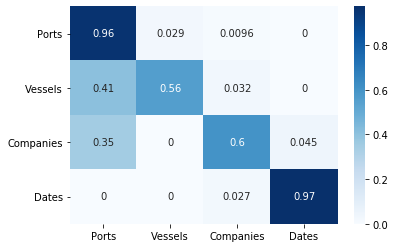

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=['Ports','Vessels','Companies','Dates'], yticklabels=['Ports','Vessels','Companies','Dates'], cmap='Blues')
ax.set_ylim(4.0, 0)
plt.show()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.59      0.96      0.73       104
           1       0.95      0.56      0.70        95
           2       0.88      0.60      0.72        88
           3       0.96      0.97      0.97       113

    accuracy                           0.79       400
   macro avg       0.85      0.77      0.78       400
weighted avg       0.84      0.79      0.79       400



**Deep Learning Implementation** (basic model)

In [27]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = 2000
embedding_dim = 16
max_length = 5
trunc_type='post'
oov_tok = '<OOV>'

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [0]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

**Cross Validation**

In [32]:
num_epochs = 30
scores = []
for train, test in kfold.split(padded, y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(padded[train], y_train[train], epochs=num_epochs, verbose=0)
  score = model.evaluate(padded[test], y_train[test], verbose=0)
  print("%s: %.2f%%" % ('Accuracy', score[1]*100))
  scores.append(score[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

Accuracy: 81.06%
Accuracy: 80.69%
Accuracy: 85.89%
Accuracy: 80.88%
Accuracy: 81.82%
82.07% (+/- 1.95%)


In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 5, 16)             32000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 486       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 28        
Total params: 32,514
Trainable params: 32,514
Non-trainable params: 0
_________________________________________________________________


In [0]:
r = model.fit(padded, y_train, epochs=num_epochs,verbose=0)

**Plotting Training Loss and Accuracy**

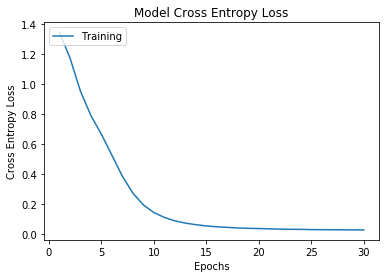

In [35]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['loss'])
#sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left');

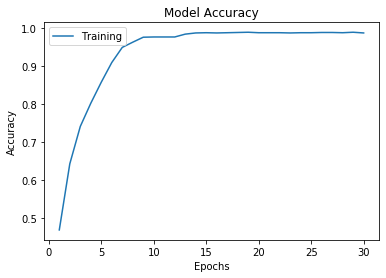

In [36]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['accuracy'])
#sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left');

**Plotting the Confusion Matrix**

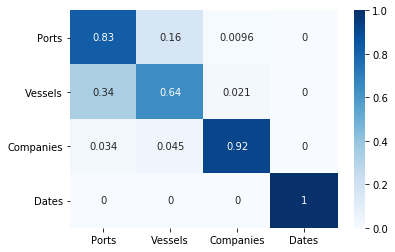

In [37]:
y_pred = model.predict(testing_padded).argmax(axis=1)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=['Ports','Vessels','Companies','Dates'], yticklabels=['Ports','Vessels','Companies','Dates'], cmap='Blues')
ax.set_ylim(4.0, 0)
plt.show()

**Print Classification Report**

In [38]:
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.76       104
           1       0.74      0.64      0.69        95
           2       0.96      0.92      0.94        88
           3       1.00      1.00      1.00       113

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



**Deep Learning (RNNs)**

Adding a bidirectional LSTM layer to see the impact on the model and cross validation scores

**Cross Validation with LSTM**

In [39]:
num_epochs = 50
scores = []
for train, test in kfold.split(padded, y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(padded[train], y_train[train], epochs=num_epochs, verbose=0)
  score = model.evaluate(padded[test], y_train[test], verbose=0)
  print("%s: %.2f%%" % ('Accuracy', score[1]*100))
  scores.append(score[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

Accuracy: 76.71%
Accuracy: 82.24%
Accuracy: 84.95%
Accuracy: 73.98%
Accuracy: 69.91%
77.56% (+/- 5.45%)


**Predicting on Test Data**

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 5, 16)             32000     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 5, 64)             12544     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 36        
Total params: 55,212
Trainable params: 55,212
Non-trainable params: 0
_________________________________________________________________


In [0]:
r = model.fit(padded, y_train, epochs=num_epochs,verbose=0)

**Plotting Loss and Accuracy**

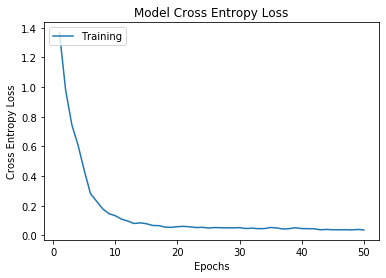

In [42]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['loss'])
#sns.lineplot(x=range(1,50+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left');

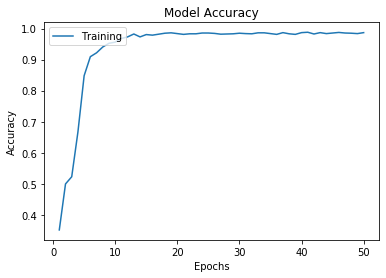

In [44]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['accuracy'])
#sns.lineplot(x=range(1,50+1),y=r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left');

**Plotting Confusion Matrix**

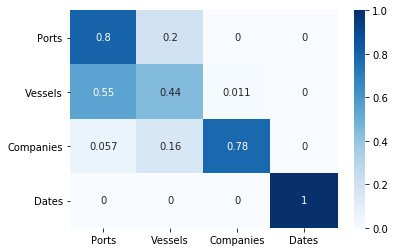

In [45]:
y_pred = model.predict(testing_padded).argmax(axis=1)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=['Ports','Vessels','Companies','Dates'], yticklabels=['Ports','Vessels','Companies','Dates'], cmap='Blues')
ax.set_ylim(4.0, 0)
plt.show()

**Print Classification Report**

In [46]:
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.59      0.80      0.68       104
           1       0.55      0.44      0.49        95
           2       0.99      0.78      0.87        88
           3       1.00      1.00      1.00       113

    accuracy                           0.77       400
   macro avg       0.78      0.76      0.76       400
weighted avg       0.78      0.77      0.77       400



**Deep Learning (CNNs)**

**Cross Validation**

In [47]:
num_epochs = 50
scores = []
for train, test in kfold.split(padded, y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(4, activation='softmax')])
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(padded[train], y_train[train], epochs=num_epochs, verbose=0)
  score = model.evaluate(padded[test], y_train[test], verbose=0)
  print("%s: %.2f%%" % ('Accuracy', score[1]*100))
  scores.append(score[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

Accuracy: 75.16%
Accuracy: 76.64%
Accuracy: 79.31%
Accuracy: 72.73%
Accuracy: 77.12%
76.19% (+/- 2.18%)


**Predicting on Test Data**

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(4, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 5, 16)             32000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 64)             2112      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 260       
Total params: 67,396
Trainable params: 67,396
Non-trainable params: 0
_________________________________________________

In [0]:
r = model.fit(padded, y_train, epochs=num_epochs,verbose=0)

**Plotting Loss and Accuracy**

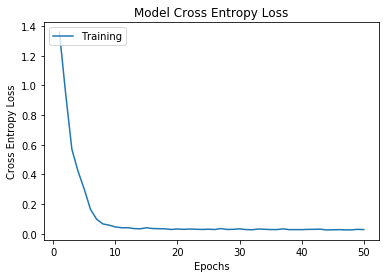

In [50]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['loss'])
#sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left');

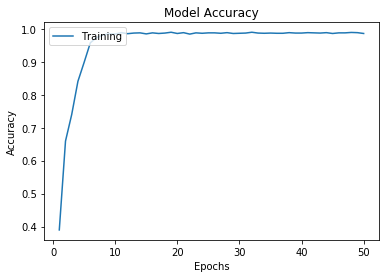

In [51]:
sns.lineplot(x=range(1,num_epochs+1),y=r.history['accuracy'])
#sns.lineplot(x=range(1,num_epochs+1),y=r.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left');

**Plotting Confusion Matrix**

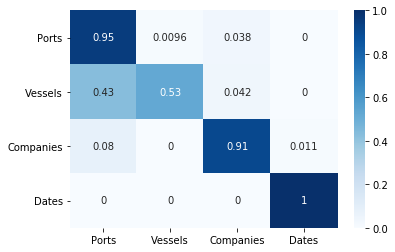

In [52]:
y_pred = model.predict(testing_padded).argmax(axis=1)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=['Ports','Vessels','Companies','Dates'], yticklabels=['Ports','Vessels','Companies','Dates'], cmap='Blues')
ax.set_ylim(4.0, 0)
plt.show()

**Print Classification Report**

In [53]:
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.67      0.95      0.79       104
           1       0.98      0.53      0.68        95
           2       0.91      0.91      0.91        88
           3       0.99      1.00      1.00       113

    accuracy                           0.85       400
   macro avg       0.89      0.85      0.84       400
weighted avg       0.89      0.85      0.85       400

